In [1]:
# import torch
# import spacy
# import en_core_web_sm
# import transformers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# find the validation set data

In [2]:
data=pd.read_csv("data_v4.csv",encoding="utf=8")

data.dropna(inplace=True)
data=data.drop_duplicates()
data["context"]=data["context"].apply(lambda x: x.replace("\n",""))
data["context_len"]=data["context"].apply(lambda x: len(x))
data=data.drop(data[data["context_len"]>512].index)


In [3]:
texts = []
questions = []
for idx, row in data.iterrows():
    texts.append(row['context'].strip())
    questions.append(row['questions'].strip())
train_texts, val_texts, train_questions, val_questions = train_test_split(
    texts, questions, test_size=0.1, random_state=2)

In [4]:
len(data)

2196

In [5]:
len(train_texts)

1976

In [6]:
len(val_texts)

220

#  result val_data before fine tune

In [7]:
t5_before=pd.read_csv("result_t5_before_val.csv",encoding="utf=8")
bart_before=pd.read_csv("result_bart_before_val.csv",encoding="utf=8")

In [8]:
t5_before=t5_before.dropna()
bart_before=bart_before.dropna()


# result val_data after fine tune

In [9]:
# # df1=pd.read_csv("result_t5_tune_v3_1.csv",encoding="utf=8")
# # df2=pd.read_csv("result_t5_tune_v3_2.csv",encoding="utf=8")
# # df3=pd.read_csv("result_t5_tune_v3_3.csv",encoding="utf=8")

# t5=pd.concat([df1,df2,df3])
# t5=t5[t5['context'].isin(val_texts)]

In [10]:
# a=pd.concat([df1,df2,df3])
# a=a.loc[a['context'].isin(val_texts),:]
# a['context_len']=a["context"].apply(lambda x: len(x))

In [11]:
# df1=pd.read_csv("result_bart_v3_1.csv",encoding="utf=8")
# df2=pd.read_csv("result_bart_v3_2.csv",encoding="utf=8")
# df3=pd.read_csv("result_bart_v3_3.csv",encoding="utf=8")

# bart=pd.concat([df1,df2,df3])
# bart=bart[bart['context'].isin(val_texts)]

In [12]:
t5=pd.read_csv("result_t5_tune_val.csv",encoding="utf=8")
bart=pd.read_csv("result_bart_tune_val.csv",encoding="utf=8")

In [13]:
t5=t5.dropna()
bart=bart.dropna()


In [14]:
len(bart)


175

# add questions_original to compare the similarity of machine-generated questions and original questions

In [15]:
data=data.rename(columns={'answers':'answers_original','questions':'questions_original'})

In [16]:
t5 = pd.merge(t5,data,how='left',on=['context'])
bart = pd.merge(bart,data,how='left',on=['context'])

In [17]:
t5_before= pd.merge(t5_before,data,how='left',on=['context'])
bart_before= pd.merge(bart_before,data,how='left',on=['context'])

# BLEU

In [22]:
import nltk
nltk.download('punkt')
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

[nltk_data] Downloading package punkt to /home/faculty/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
def add_bleu(df):

#     import nltk
#     nltk.download('punkt')
#     from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
#     from nltk.translate.bleu_score import SmoothingFunction
    

    df["questions_token"]=df["questions"].apply(lambda x: nltk.word_tokenize(str(x).rstrip('?:!.,;')))
    df["questions_original_token"]=df["questions_original"].apply(lambda x: nltk.word_tokenize(str(x).rstrip('?:!.,;')))
    
    df["bleu1"] = df.apply(lambda x: round(sentence_bleu([x["questions_token"]],x["questions_original_token"],
                                       weights = (1,0,0,0),
                                       smoothing_function=SmoothingFunction().method1),3), axis=1)
#     df["bleu2"] = df.apply(lambda x: round(sentence_bleu([x["questions_token"]],x["questions_original_token"],
#                                        weights = (0,1,0,0),
#                                        smoothing_function=SmoothingFunction().method1),3), axis=1)
#     df["bleu3"] = df.apply(lambda x: round(sentence_bleu([x["questions_token"]],x["questions_original_token"],
#                                        weights = (0,0,1,0),
#                                        smoothing_function=SmoothingFunction().method1),3), axis=1)
#     df["bleu4"] = df.apply(lambda x: round(sentence_bleu([x["questions_token"]],x["questions_original_token"],
#                                        weights = (0,0,0,1),
#                                        smoothing_function=SmoothingFunction().method1),3), axis=1)

# rough

In [24]:
def add_rouge(df):
    from rouge import Rouge
#     import nltk
#     nltk.download('punkt')
#     from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
#     from nltk.translate.bleu_score import SmoothingFunction
    rouge = Rouge()
    df["rouge1"] = df.apply(lambda x: round(rouge.get_scores(str(x["questions"]), str(x["questions_original"]))[0]['rouge-1']['r'],3), axis=1)

# meteor

In [25]:
def add_meteor(df):
    from nltk.translate.meteor_score import meteor_score
    df["meteor"] = df.apply(lambda x: round(meteor_score(str(x["questions"]), str(x["questions_original"])),3), axis=1)

# add BLEU,ROUGH,METEOR

In [26]:
add_bleu(t5_before)
add_bleu(t5)
add_rouge(t5_before)
add_rouge(t5)
add_meteor(t5_before)
add_meteor(t5)


add_bleu(bart_before)
add_bleu(bart)
add_rouge(bart_before)
add_rouge(bart)
add_meteor(bart_before)
add_meteor(bart)

# compare fine tuned model on bleu, rouge,meteor

In [27]:
compare=pd.concat([t5.bleu1, bart.bleu1,
                   t5.rouge1,bart.rouge1,
                   t5.meteor,bart.meteor],axis=1)
compare.columns=['t5.bleu1','bart.bleu1','t5.rouge1','bart.rouge1','t5.meteor','bart.meteor']
compare.describe()

,t5.bleu1,bart.bleu1,t5.rouge1,bart.rouge1,t5.meteor,bart.meteor
count,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000
mean,0.405553,0.375853,0.407792,0.372051,0.057000,0.055244
std,0.252561,0.262783,0.282152,0.292173,0.104848,0.102978
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.202000,0.111000,0.143000,0.111000,0.000000,0.000000
50%,0.333000,0.333000,0.333000,0.364000,0.000000,0.000000
75%,0.556000,0.538000,0.625000,0.571000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,0.357000,0.357000


# compare before fine tune and after fine tune

## compare on bleu

In [28]:
bleu_compare=pd.concat([t5_before.bleu1,t5.bleu1,bart_before.bleu1,bart.bleu1],axis=1)
bleu_compare.columns=['t5_before','t5_tune','bart_before','bart_tune']
bleu_compare.describe()

,t5_before,t5_tune,bart_before,bart_tune
count,197.000000,197.000000,197.000000,197.000000
mean,0.282843,0.405553,0.305843,0.375853
std,0.186956,0.252561,0.198927,0.262783
min,0.000000,0.000000,0.000000,0.000000
25%,0.125000,0.202000,0.195000,0.111000
50%,0.333000,0.333000,0.222000,0.333000
75%,0.353000,0.556000,0.400000,0.538000
max,0.800000,1.000000,1.000000,1.000000


## compare on rouge

In [29]:
rouge_compare=pd.concat([t5_before.rouge1,t5.rouge1,bart_before.rouge1,bart.rouge1],axis=1)
rouge_compare.columns=['t5_before','t5_tune','bart_before','bart_tune']
rouge_compare.describe()

,t5_before,t5_tune,bart_before,bart_tune
count,197.000000,197.000000,197.000000,197.000000
mean,0.254970,0.407792,0.315147,0.372051
std,0.202548,0.282152,0.228583,0.292173
min,0.000000,0.000000,0.000000,0.000000
25%,0.125000,0.143000,0.143000,0.111000
50%,0.200000,0.333000,0.250000,0.364000
75%,0.375000,0.625000,0.444000,0.571000
max,0.889000,1.000000,1.000000,1.000000


## compare on meteor

In [30]:
meteor_compare=pd.concat([t5_before.meteor,t5.meteor,bart_before.meteor,bart.meteor],axis=1)
meteor_compare.columns=['t5_before','t5_tune','bart_before','bart_tune']
meteor_compare.describe()

,t5_before,t5_tune,bart_before,bart_tune
count,197.000000,197.000000,197.000000,197.000000
mean,0.055772,0.057000,0.056959,0.055244
std,0.104019,0.104848,0.104791,0.102978
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.357000,0.357000,0.357000,0.357000


In [ ]:
t5

# types of questions

In [31]:
join=pd.merge(bart,t5,how='left',on=['context'])

join["first_word"]=join["questions_original_x"].apply(lambda x: nltk.word_tokenize(str(x))[0]) #分词


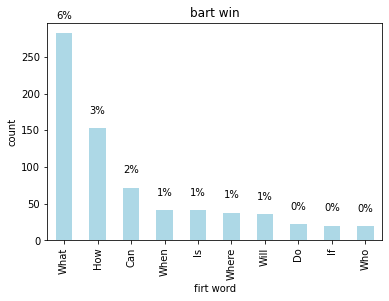

In [159]:
ax=join.loc[join.bleu1_x>join.bleu1_y,"first_word"].value_counts()[0:10].plot(kind='bar', color='lightblue')
plt.title('bart win')
plt.xlabel("firt word")
plt.ylabel("count")
for p in ax.patches:
    height = p.get_height()
    total = 4410
    ax.text(p.get_x() + p.get_width()/2., height + 20, '{0:.0%}'.format(height/total), ha="center")

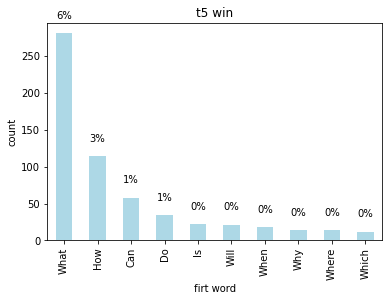

In [164]:
ax=join.loc[join.bleu1_x<join.bleu1_y,"first_word"].value_counts()[0:10].plot(kind='bar', color='lightblue')
plt.title('t5 win')
plt.xlabel("firt word")
plt.ylabel("count")
for p in ax.patches:
    height = p.get_height()
    total = 4410
    ax.text(p.get_x() + p.get_width()/2., height + 20, '{0:.0%}'.format(height/total), ha="center")

In [50]:
t=t5.drop_duplicates("context")
b=bart.drop_duplicates("context")
join=pd.merge(b,t,how='left',on=['context'])
len(join)

153

# length of context

In [77]:
bin_i = pd.qcut(join["context_len_x"], q = 50,duplicates="drop")
bleu_score=join["bleu1_x"]
len_bleu=pd.concat([bin_i,bleu_score],axis = 1)
mean=len_bleu.groupby(["context_len_x"]).mean()


bleu_score=join["bleu1_y"]
len_bleu=pd.concat([bin_i,bleu_score],axis = 1)
mean1=len_bleu.groupby(["context_len_x"]).mean()

both=pd.concat([mean,mean1],axis = 1)


/opt/anaconda/envs/Python3/lib/python3.8/site-packages/matplotlib/axes/_base.py:405: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


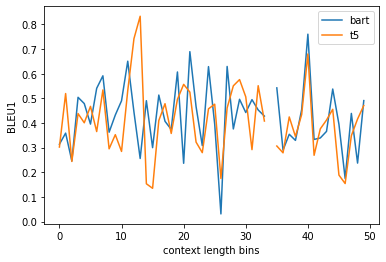

In [78]:
import matplotlib.pyplot as plt
plt.plot(both["bleu1_x"],label="bart")
plt.plot(both["bleu1_y"],label="t5")
# plt.title('bart win')
plt.xlabel("context length bins")
plt.ylabel("BLEU1")
plt.legend()

In [80]:
join["first_word"]=join["questions_original_x"].apply(lambda x: nltk.word_tokenize(str(x))[0]) #分词

In [81]:
join["first_word_en"]=join["first_word"].apply(lambda x: x.isalpha())

In [82]:
join.loc[0,"first_word_en"] == True

True

In [83]:
first_word_bart=join.loc[join.first_word_en == True,:].groupby(["first_word"])["bleu1_x"].mean()
first_word_t5=join.loc[join.first_word_en == True,:].groupby(["first_word"])["bleu1_y"].mean()
first_word_score=pd.concat([first_word_bart,first_word_t5],axis=1)

# plt.plot(first_word_score.iloc[0:10,:])

In [91]:
first_word_score.reset_index(inplace=True)

In [93]:
first_word_score["first_word"]=first_word_score["first_word"].apply(lambda x: x.lower())

In [104]:
rank=first_word_score[first_word_score['first_word'].isin(["what","when","who","where","why","how" ])
                ].sort_values(by=["bleu1_x"],ascending=False)

In [105]:
rank.columns=['first_word',"bart",'t5']

In [106]:
rank

,first_word,bart,t5
12,where,0.518667,0.281500
10,what,0.441946,0.450589
5,how,0.411756,0.400098
11,when,0.377000,0.274000
14,who,0.303000,0.515500


In [103]:
join.to_csv("result/join_final.csv",encoding='utf-8-sig')